In [1]:
# imports
import os
import glob
import numpy as np
from PIL import Image 
import matplotlib.pyplot as plt
import random
from albumentations import Compose, HorizontalFlip, Rotate, GaussNoise, Blur, RandomBrightnessContrast, OneOf

# Data

In [2]:
PATCH_SIZE = 32
NUM_CHANNELS = 3 # HH, HV, Inc. Angle

CLASS_NAMES = [
    "OpenWater",
    "Leads withWater",
    "Brash/Pancake Ice",
    "Thin Ice",
    "Thick Ice-Flat",
    "Thick Ice-Ridged"
]
NUM_TOTAL_CLASSES = len(CLASS_NAMES)

DATA_ROOT = "Patches32x32\\32"

In [3]:
def load_data(data_root, isBinaryClassification=True):
    X = []  # To store patches
    y = []  # To store labels (class indices)

    print("Starting data loading...")
    
    for class_index in range(NUM_TOTAL_CLASSES):
        class_dir = os.path.join(data_root, str(class_index))

        if not os.path.exists(class_dir):
            raise FileNotFoundError(f"Directory {class_dir} does not exist")
            
        patch_files = glob.glob(os.path.join(class_dir, '*')) 

        actual_class = (0 if class_index <= 1 else 1) if isBinaryClassification else class_index # keep 0 for water, 1 for ice
        
        print(f"Found {len(patch_files)} patches for class: {actual_class}")

        for file_path in patch_files:
            try:
                img = Image.open(file_path)
                patch = np.array(img, dtype=np.float32)
                
                X.append(patch)
                y.append(actual_class)
                    
            except Exception as e:
                print(f"Error loading {file_path}: {e}")

    X = np.array(X, dtype=np.float32) 
    y = np.array(y, dtype=np.int64)

    print(f"\n--- Data Load Complete ---")
    print(f"Total patches loaded: {len(X)}")
    print(f"Shape of Data (X): {X.shape}")
    print(f"Shape of Labels (y): {y.shape}")
    
    return X, y

In [4]:
X_data, y_labels = load_data(DATA_ROOT)

Starting data loading...
Found 8394 patches for class: 0


KeyboardInterrupt: 

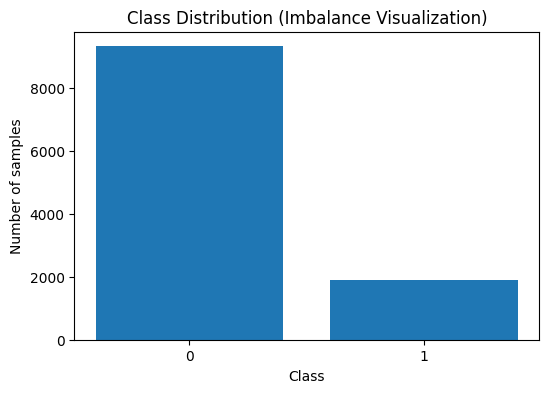

In [ ]:
unique, counts = np.unique(y_labels, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar(unique, counts, tick_label=[str(int(u)) for u in unique])
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Binary-Class Distribution (before augmentation)")
plt.show()

In [ ]:
# Normalization Function
def normalize_sar_data(X_data):    
    X_normalized = np.copy(X_data).astype(np.float32)
    
    # Iterate through each of the three channels
    for channel_index in range(X_data.shape[-1]):
        # Select the data for the current channel across all samples
        channel_data = X_data[..., channel_index]
        mu = channel_data.mean()
        sigma = channel_data.std()

        
        print(f"Channel {channel_index} - min before norm: {channel_data.min()}, max before norm: {channel_data.max()}")
        X_normalized[..., channel_index] = (channel_data - mu) / sigma
        print(f"Channel {channel_index} - min after norm: {X_normalized[..., channel_index].min()}, max after norm: {X_normalized[..., channel_index].max()}")
        
    return X_normalized

X_data_normalized = normalize_sar_data(X_data)

In [ ]:
MINOR_CLASS_THRESHOLD = 4000
def oversample_minority_classes(X_train, y_train, class_counts, target_count, pipeline):
    """
    Augments patches from minority classes until they reach the target count.
    """
    X_augmented = []
    y_augmented = []
    
    # Group original patches by class index
    patches_by_class = {i: [] for i in range(len(class_counts))}
    for patch, label in zip(X_train, y_train):
        patches_by_class[label].append(patch)
        
    for class_index, current_count in class_counts.items():
        print(f"\nProcessing Class {class_index}: {current_count} original patches.")

        if current_count >= MINOR_CLASS_THRESHOLD:
            # Majority Class: Use all original patches
            X_augmented.extend(patches_by_class[class_index])
            y_augmented.extend([class_index] * current_count)
            print("Status: Majority, using original patches only.")
        else:
            # Minority Class: Augment until target is met
            original_patches = patches_by_class[class_index]
            generated_count = current_count
            
            # Start with original patches
            X_augmented.extend(original_patches)
            y_augmented.extend([class_index] * current_count)

            # Augmentation loop
            while generated_count < target_count:
                # Randomly select a patch from the original set to augment
                original_patch_to_augment = random.choice(original_patches)
                
                # Apply the pipeline
                augmented_patch = pipeline(image=original_patch_to_augment)['image']
                
                X_augmented.append(augmented_patch)
                y_augmented.append(class_index)
                generated_count += 1
            
            print(f"Status: Minority. Augmented to {generated_count} patches.")

    X_final = np.array(X_augmented)
    y_final = np.array(y_augmented)

    return X_final, y_final


In [ ]:
# They used the following strategy for data augmentation:
# horizontal flip, rotation with 90 degrees, blurring, and random changes to both brightness and contrast. 
# We are doing the same
def create_augmentation_pipeline(p_transform=0.5):
    """
    Creates an Albumentations pipeline for the specified sea ice augmentations.
    
    Args:
        p_transform (float): Probability of applying the entire set of transformations 
                             (e.g., 0.5 means a 50% chance of augmentation).
    """
    return Compose([
        HorizontalFlip(p=p_transform),
        Rotate(limit=(90, 90), p=p_transform),
        OneOf([
            Blur(blur_limit=3, p=0.5),
            GaussNoise(var_limit=(10.0, 50.0), p=0.5),
        ], p=p_transform),
        RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=p_transform),
    ], p=1.0) # Apply the Compose pipeline every time it is called

augmentation_pipeline = create_augmentation_pipeline(p_transform=0.7) 

C:\Users\lisas\AppData\Local\Temp\ipykernel_27376\208081489.py:22: UserWarning: Argument(s) 'var_limit' are not valid for transform GaussNoise
  GaussNoise(var_limit=(10.0, 50.0), p=0.5), # Adding some noise can also aid robustness


In [ ]:
TARGET_PATCH_COUNT = 8400

class_counts = {i: counts[i] for i in range(len(counts))}

X_data_balanced, y_labels_balanced = oversample_minority_classes(
    X_data_normalized, 
    y_labels, 
    class_counts, 
    TARGET_PATCH_COUNT, 
    augmentation_pipeline
)

print(f"\nFinal Balanced Dataset Size: {len(X_data_balanced)}")


Processing Class 0: 9318 original patches.
Status: Majority, using original patches only.

Processing Class 1: 8400 original patches.
Status: Majority, using original patches only.

Final Balanced Dataset Size: 11200


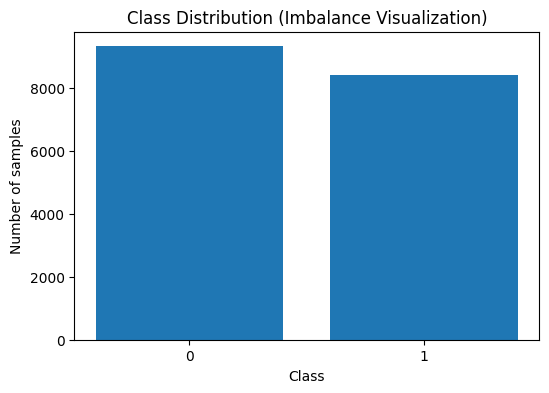

In [ ]:
unique, counts = np.unique(y_labels_balanced, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar(unique, counts, tick_label=[str(int(u)) for u in unique])
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Binary-Class Distribution (after augmentation)")
plt.show()

# Model

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical

In [ ]:
WEIGHT_DECAY = 5e-4
DROPOUT_RATE = 0.5

MY_RANDOM_SEED = 42
np.random.seed(MY_RANDOM_SEED)

In [ ]:
def vgg16_model(num_classes, input_shape=(PATCH_SIZE, PATCH_SIZE, NUM_CHANNELS)):
    model = Sequential()
    
    # --- Convolutional Blocks ---
    # Block 1: 2x Conv(64) + MaxPooling
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', 
                     input_shape=input_shape, kernel_regularizer=l2(WEIGHT_DECAY)))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(WEIGHT_DECAY)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    
    # Block 2: 2x Conv(128) + MaxPooling
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(WEIGHT_DECAY)))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(WEIGHT_DECAY)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    
    # Block 3: 3x Conv(256) + MaxPooling
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(WEIGHT_DECAY)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(WEIGHT_DECAY)))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(WEIGHT_DECAY)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    
    # Block 4: 3x Conv(512) + MaxPooling
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(WEIGHT_DECAY)))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(WEIGHT_DECAY)))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(WEIGHT_DECAY)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    
    # --- Block 5 (Modified): 3x Conv(512) ---
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(WEIGHT_DECAY)))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(WEIGHT_DECAY)))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same',
                     kernel_regularizer=l2(WEIGHT_DECAY)))
    
    # *** Final Max-Pooling layer is OMITTED ***
    
    # --- Classification Head ---
    model.add(Flatten()) # Prepare for fully connected layers

    # Fully Connected Layer 1
    model.add(Dense(1024, activation='relu', kernel_regularizer=l2(WEIGHT_DECAY))) 
    model.add(Dropout(DROPOUT_RATE))
    
    # Fully Connected Layer 2
    model.add(Dense(512, activation='relu', kernel_regularizer=l2(WEIGHT_DECAY)))
    model.add(Dropout(DROPOUT_RATE)) 
    
    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

## Binary Classification

In [ ]:
BATCH_SIZE = 20
LEARNING_RATE = 0.0001
NUM_EPOCHS = 10

binary_num_classes = 2

In [ ]:
binary_vgg16 = vgg16_model(num_classes = binary_num_classes)
binary_vgg16.summary()

In [ ]:
y_labels_balanced_one_hot = to_categorical(y_labels_balanced, num_classes = binary_num_classes)

binary_vgg16.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Epoch 1/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 157s 641ms/step - accuracy: 0.8590 - loss: 2.1693 - val_accuracy: 0.9022 - val_loss: 1.4155
Epoch 2/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 158s 879ms/step - accuracy: 0.9029 - loss: 1.1073 - val_accuracy: 0.9004 - val_loss: 0.8871
Epoch 3/10
180/180 ━━━━━━━━━━━━━━━━━━━━ 205s 1s/step - accuracy: 0.9092 - loss: 0.7631 - val_accuracy: 0.9156 - val_loss: 0.6574
Epoch 4/10
 77/180 ━━━━━━━━━━━━━━━━━━━━ 1:39 969ms/step - accuracy: 0.9128 - loss: 0.6568

KeyboardInterrupt: 

In [ ]:
# shuffle data
num_samples = X_data_balanced.shape[0]
shuffled_indices = np.random.permutation(num_samples)
X_data_shuffled = X_data_balanced[shuffled_indices]
y_labels_shuffled = y_labels_balanced_one_hot[shuffled_indices]

history = binary_vgg16.fit(
    X_data_shuffled, 
    y_labels_shuffled, 
    batch_size=BATCH_SIZE, 
    epochs=NUM_EPOCHS, 
    validation_split=0.2
)

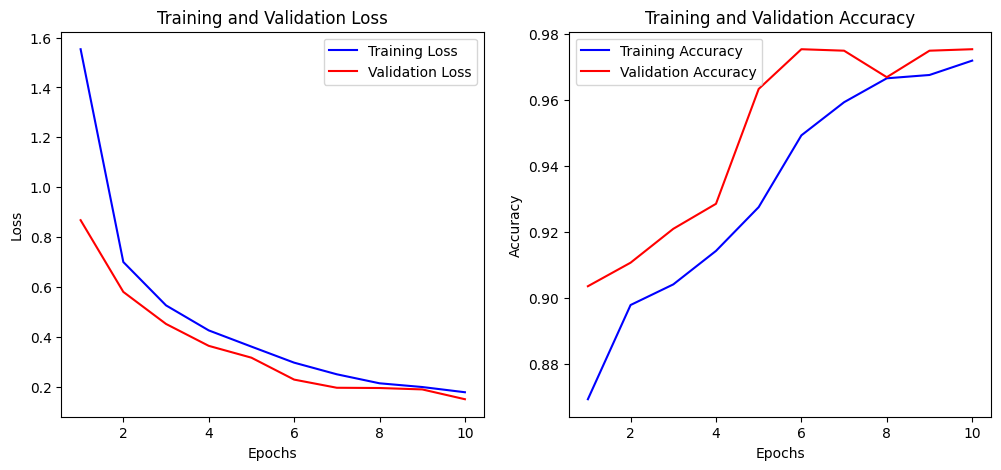

In [ ]:
history_dict = history.history

# --- Loss ---
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

plt.plot(NUM_EPOCHS, history_dict['loss'], 'b', label='Training Loss')
plt.plot(NUM_EPOCHS, history_dict['val_loss'], 'r', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# --- Accuracy ---
plt.subplot(1, 2, 2)

plt.plot(NUM_EPOCHS, history_dict['accuracy'], 'b', label='Training Accuracy')
plt.plot(NUM_EPOCHS, history_dict['val_accuracy'], 'r', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Multi-class

## Data Preparation

In [ ]:
X_data, y_labels = load_data(DATA_ROOT, False)

Starting data loading...
Found 8394 patches for class: 0
Found 924 patches for class: 1
Found 159 patches for class: 2
Found 202 patches for class: 3
Found 213 patches for class: 4
Found 1308 patches for class: 5

--- Data Load Complete ---
Total patches loaded: 11200
Shape of Data (X): (11200, 32, 32, 3)
Shape of Labels (y): (11200,)


In [ ]:
X_data_normalized = normalize_sar_data(X_data)

Channel 0 - min before norm: 0.0, max before norm: 255.0
Channel 0 - min after norm: -1.1437098979949951, max after norm: 3.2642016410827637
Channel 1 - min before norm: 0.0, max before norm: 255.0
Channel 1 - min after norm: -1.1439812183380127, max after norm: 3.2702577114105225
Channel 2 - min before norm: 0.0, max before norm: 255.0
Channel 2 - min after norm: -1.144775629043579, max after norm: 3.272402286529541


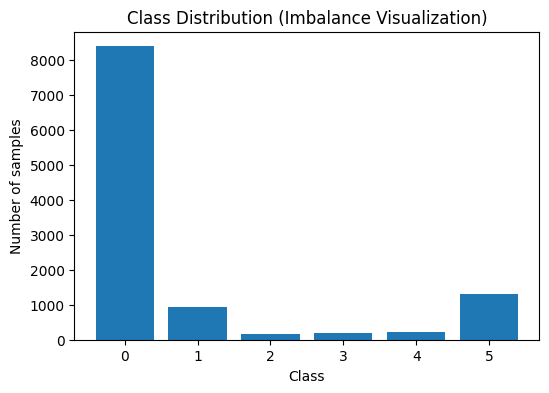

In [ ]:
unique, counts = np.unique(y_labels, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar(unique, counts, tick_label=[str(int(u)) for u in unique])
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Multi-Class Distribution (before augmentation)")
plt.show()

In [ ]:
TARGET_PATCH_COUNT = 8400

class_counts = {i: counts[i] for i in range(len(counts))}
print(class_counts)

{0: np.int64(8394), 1: np.int64(924), 2: np.int64(159), 3: np.int64(202), 4: np.int64(213), 5: np.int64(1308)}


In [ ]:
X_data_balanced, y_labels_balanced = oversample_minority_classes(
    X_data_normalized, 
    y_labels, 
    class_counts, 
    TARGET_PATCH_COUNT, 
    augmentation_pipeline
)

print(f"\nFinal Balanced Dataset Size: {len(X_data_balanced)}")


Processing Class 0: 8394 original patches.
Status: Majority, using original patches only.

Processing Class 1: 924 original patches.
Status: Minority. Augmented to 8400 patches.

Processing Class 2: 159 original patches.
Status: Minority. Augmented to 8400 patches.

Processing Class 3: 202 original patches.
Status: Minority. Augmented to 8400 patches.

Processing Class 4: 213 original patches.
Status: Minority. Augmented to 8400 patches.

Processing Class 5: 1308 original patches.
Status: Minority. Augmented to 8400 patches.

Final Balanced Dataset Size: 50394


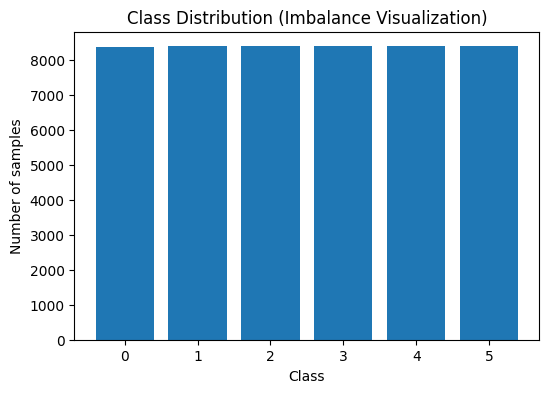

: 

In [ ]:
unique, counts = np.unique(y_labels_balanced, return_counts=True)

plt.figure(figsize=(6,4))
plt.bar(unique, counts, tick_label=[str(int(u)) for u in unique])
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Multi-Class Distribution (after augmentation)")
plt.show()

## Model Instantiation for Multi-Class

In [ ]:
BATCH_SIZE = 20
LEARNING_RATE = 0.0001
NUM_EPOCHS = 10

In [ ]:
multi_vgg16 = vgg16_model(num_classes=6)
multi_vgg16.summary()

In [ ]:
y_labels_balanced_one_hot = to_categorical(y_labels_balanced, num_classes=6)

multi_vgg16.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE), 
    loss='categorical_crossentropy', # Cross-entropy loss function
    metrics=['accuracy']
)

In [ ]:
num_samples = X_data_balanced.shape[0]
shuffled_indices = np.random.permutation(num_samples)

X_data_shuffled = X_data_balanced[shuffled_indices]
y_labels_shuffled = y_labels_balanced_one_hot[shuffled_indices]

history = multi_vgg16.fit(
    X_data_shuffled, 
    y_labels_shuffled, 
    batch_size=BATCH_SIZE, 
    epochs=NUM_EPOCHS, 
    validation_split=0.2
)

c:\Users\lisas\miniconda3\envs\flora_env\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 667s 329ms/step - accuracy: 0.4869 - loss: 1.7610 - val_accuracy: 0.5849 - val_loss: 1.2747
Epoch 2/10
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 683s 339ms/step - accuracy: 0.5875 - loss: 1.2144 - val_accuracy: 0.6216 - val_loss: 1.1161
Epoch 3/10
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 578s 287ms/step - accuracy: 0.6226 - loss: 1.1046 - val_accuracy: 0.6582 - val_loss: 1.0214
Epoch 4/10
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 542s 269ms/step - accuracy: 0.6424 - loss: 1.0309 - val_accuracy: 0.6321 - val_loss: 1.0189
Epoch 5/10
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 572s 284ms/step - accuracy: 0.6516 - loss: 0.9880 - val_accuracy: 0.6737 - val_loss: 0.9461
Epoch 6/10
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 492s 244ms/step - accuracy: 0.6590 - loss: 0.9589 - val_accuracy: 0.6708 - val_loss: 0.9420
Epoch 7/10
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 619s 307ms/step - accuracy: 0.6661 - loss: 0.9352 - val_accuracy: 0.6704 - val_loss: 0.9179
Epoch 8/10
2016/2016 ━━━━━━━━━━━━━━━━━━━━ 489s 242ms/step - ac

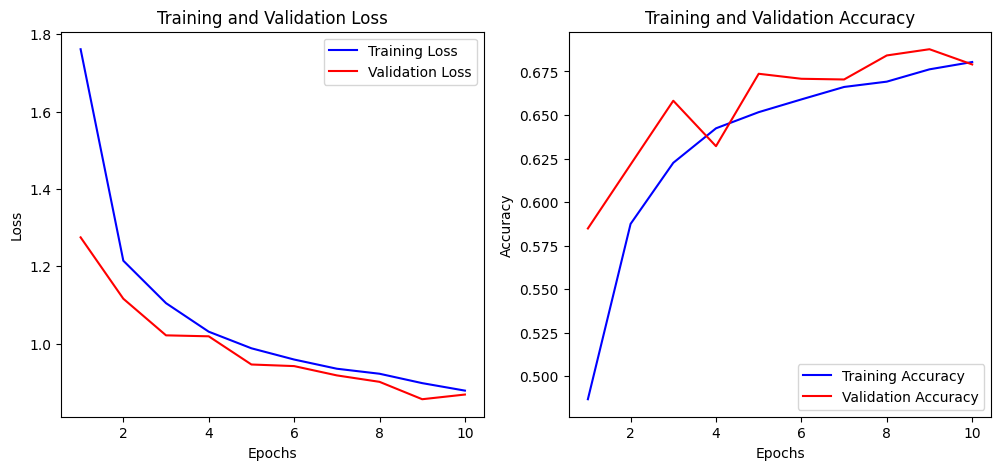

In [ ]:
history_dict = history.history


# Loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)

plt.plot(NUM_EPOCHS, history_dict['loss'], 'b', label='Training Loss')
plt.plot(NUM_EPOCHS, history_dict['val_loss'], 'r', label='Validation Loss')

plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy
plt.subplot(1, 2, 2)

plt.plot(NUM_EPOCHS, history_dict['accuracy'], 'b', label='Training Accuracy')
plt.plot(NUM_EPOCHS, history_dict['val_accuracy'], 'r', label='Validation Accuracy')

plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()